In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import rasterio as rio
import folium
import cv2 as cv

In [2]:
lat=18.200178; lon=-66.064513
def overlay_image_on_puerto_rico(data, band_layer=2, cmap=lambda x: (1, 0, 0, x)):
    band = data
    m = folium.Map([lat, lon], zoom_start=9.45)
    folium.raster_layers.ImageOverlay(
        image=band,clip
        bounds = [[18.6,-67.3,],[17.9,-65.2]],
        colormap = cmap,
        origin='lower'
    ).add_to(m)
    return m

def readFile(name):
    image= rio.open(name)
    return(image)

def inpaintImg(im, setZero=False):
    row, col = im.shape
    avg_val = np.average(im)
    if setZero:
        im = im.clip(min=0)
        im = np.nan_to_num(x=im, nan=0)
    else:
        mask = np.ones((row+2,col+2))
        mask[1:-1,1:-1] = np.isnan(im)
        mask = np.uint8(mask)
        new_im = np.ones((row+2,col+2))*avg_val
        new_im[1:-1,1:-1] = im
        new_im = np.float32(new_im)
        new_im = np.float64(cv.inpaint(new_im, mask, 3, cv.INPAINT_NS)) # Inpaints using Navier-Stokes 
        new_im = new_im.clip(min=0) # sets negative values to zero
        im = new_im[1:-1,1:-1]
    return im #im

In [3]:
import pathlib
def dataLoader(folder):
    p = "./eie_data/"
    for path in pathlib.Path(p+folder+"/").iterdir():
        if path.is_file():
            image= rio.open(path)
            band2 = image.read(2)
            if np.sum(np.isnan(band2)) <= image.shape[0]*image.shape[1]*0.05:
                yield(image)
            
loader_s5p = dataLoader("s5p_no2")
#loader_gfs = dataLoader("gfs")
#loader_gldas = dataLoader("gldas")

We first calculate various statistics:

In [4]:
pic = readFile('./eie_data/s5p_no2/s5p_no2_20190504T165553_20190510T183608.tif')
pic.name.split("/")[-1][:-4]

's5p_no2_20190504T165553_20190510T183608'

## Test dataloader

In [5]:
loader_s5p = dataLoader("s5p_no2")

In [6]:
# Creates NA-map
#img = next(loader_s5p)
#img = readFile("eie_data\cleaned_s5p_no2\cleaned_s5p_no2_20180712T160623_20180719T105633.tif")
#img2 = readFile("eie_data\s5p_no2\s5p_no2_20180706T161914_20180712T200737.tif")
#img3 = readFile("eie_data\s5p_no2\s5p_no2_20181229T160630_20190104T181035.tif")
img4 = readFile("eie_data\s5p_no2\s5p_no2_20180716T163137_20180722T180949.tif")
#img5 = readFile("eie_data\s5p_no2\s5p_no2_20190424T164221_20190501T013253.tif")
#img6 = readFile("eie_data\s5p_no2\s5p_no2_20180927T165725_20181003T182739.tif")

print(img4.name)
im = img4.read(2)
lst = []
for i, item1 in enumerate(im):
    for j, item2 in enumerate(item1):
        if np.isnan(item2):
            lst.append([i,j])
lst = np.array(lst)
print("len list: ", len(lst))
print("NA Count: ", np.sum(np.isnan(im)))

eie_data\s5p_no2\s5p_no2_20180716T163137_20180722T180949.tif
len list:  589
NA Count:  589


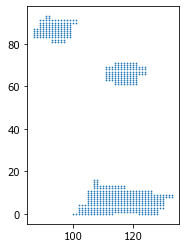

In [7]:
if len(lst) > 0:
    plt.subplot(1, 2, 1)
    plt.scatter(lst[:,0], lst[:,1], s=0.5)

In [8]:
import matplotlib.cm as cm
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

In [9]:
# Choose colormap
cmap = cm.get_cmap('Reds')
# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))
# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
# Create new colormap
my_cmap = ListedColormap(my_cmap)

In [10]:
mn = 0.0
mx = 6.750725398368169e-05
norm = matplotlib.colors.Normalize(vmin=mn, vmax=mx, clip=False)
cmap = cm.ScalarMappable(norm=norm, cmap=my_cmap)

In [11]:
t = inpaintImg(im, True)
print("min: ", np.min(t))
print("max: ", np.max(t))
overlay_image_on_puerto_rico(t, cmap=cmap.to_rgba)

min:  0.0
max:  0.00011369495041435584


## Clean Data

In [27]:
# Only 128 images does not contain NA-values in the second band.
# If we accept all pictures with less than 5% NA values we get 324 images.
# A total of 387 images are availible.

In [15]:
# Save names of all valid pictures in order:
loader_s5p = dataLoader("s5p_no2")
s5p_order = []
for img in loader_s5p:
    date = img.name.split("\\")[-1].split("_")[-2][:8]
    s5p_order.append([date, img.name])
# Date ordered:
s5p_order.sort(key=(lambda x: x[0]))   
# Number of valid pictures:
print("Number of availible images: ", len(s5p_order))

Number of availible images:  324


In [13]:
# Write images to new folder:
def writeCleanData(s5p_order):
    for i, [date, name] in enumerate(s5p_order):
        pic = readFile(name)
        new_dataset = rio.open(name.replace("s5p_no2", "cleaned_s5p_no2"),
                               "w",
                               driver=pic.meta['driver'],
                               dtype=pic.meta['dtype'],
                               height=pic.meta['height'],
                               width=pic.meta['width'],
                               count=pic.meta['count'],
                               crs=pic.meta['crs'],
                               transform=pic.meta['transform'])
        band =pic.read(2)
        band = inpaintImg(band)
        new_dataset.write(band, 2)
        new_dataset.close()
    return

# Write images to new folder:

artifactlist = ["eie_data\cleaned_s5p_no2\cleaned_s5p_no2_20180927T165725_20181003T182739.tif",
                "eie_data\cleaned_s5p_no2\cleaned_s5p_no2_20180828T162223_20180903T175125.tif",
                "eie_data\cleaned_s5p_no2\cleaned_s5p_no2_20180822T163536_20180828T180827.tif",
                "eie_data\cleaned_s5p_no2\cleaned_s5p_no2_20180719T171554_20180725T185631.tif"]

def writeCleanDataAvg(s5p_order, lag=7):
    temp_frames = []
    c=0
    for i, [date, name] in enumerate(s5p_order):
        pic = readFile(name)
        band = pic.read(2)
        band = inpaintImg(band)
        if name in artifactlist:
            print("continues")
            continue
        if c < lag:
            temp_frames.append(band)
            c+=1
        else:
            new_dataset = rio.open(name.replace("s5p_no2", "cleaned_s5p_no2_avg"),
                                   "w",
                                   driver=pic.meta['driver'],
                                   dtype=pic.meta['dtype'],
                                   height=pic.meta['height'],
                                   width=pic.meta['width'],
                                   count=pic.meta['count'],
                                   crs=pic.meta['crs'],
                                   transform=pic.meta['transform'])
            temp_frames = temp_frames[1:]
            temp_frames.append(band)
            temp_frames_np = np.array(temp_frames)
            avg_band = np.average(temp_frames_np, axis=0)
            new_dataset.write(avg_band, 2)
            new_dataset.close()
    return
#writeCleanData(s5p_order)

In [16]:
s5p_order_c = s5p_order
for i, [date, name] in enumerate(s5p_order_c):
    s5p_order_c[i] = [date, name.replace("s5p_no2", "cleaned_s5p_no2")]

## Visualize NO2 on Puerto Rico

In [17]:
def loadValid(lst):
    for i, row in enumerate(lst):
        image= rio.open(row[1])
        yield(image)
def loadDiff(lst):
    for i, row in enumerate(lst):
        if i!=0:
            image1= rio.open(lst[i-1][1])
            image2= rio.open(lst[i][1])
            img=image2.read(2)-image1.read(2)
            yield(img)

s5p_clean_loader = loadValid(s5p_order_c)
#s5p_inorder_diff = loadDiff(s5p_order)

In [18]:
import math
#m = 0.00019466211961116649
#m=8.78659099e-05
mx=0
mn = 100000

lag=7
c=0
temp_frames = []
artifactlist = ["eie_data\cleaned_s5p_no2\cleaned_s5p_no2_20180927T165725_20181003T182739.tif",
                "eie_data\cleaned_s5p_no2\cleaned_s5p_no2_20180828T162223_20180903T175125.tif",
                "eie_data\cleaned_s5p_no2\cleaned_s5p_no2_20180822T163536_20180828T180827.tif",
                "eie_data\cleaned_s5p_no2\cleaned_s5p_no2_20180719T171554_20180725T185631.tif"]

for frame in s5p_clean_loader:
    bd = frame.read(2)
    if frame.name in artifactlist:
        print("continues")
        continue
    if c < lag:
        temp_frames.append(bd)
        c+=1
    else:
        temp_frames = temp_frames[1:]
        temp_frames.append(bd)
        avg_bd = np.average(temp_frames, axis=0)
        mn = min(mn, np.min(avg_bd))
        mx = max(mx, np.max(avg_bd))

continues
continues
continues
continues


In [19]:
print("min:", mn)
print("max:", mx)

min: 0.0
max: 4.3067126430936954e-05


In [20]:
import selenium.webdriver

driver = selenium.webdriver.PhantomJS()
driver.set_window_size(950, 380)  # choose a resolution

lag=7
c=0
temp_frames = []
artifactlist = ["eie_data\cleaned_s5p_no2\cleaned_s5p_no2_20180927T165725_20181003T182739.tif",
                "eie_data\cleaned_s5p_no2\cleaned_s5p_no2_20180828T162223_20180903T175125.tif",
                "eie_data\cleaned_s5p_no2\cleaned_s5p_no2_20180822T163536_20180828T180827.tif",
                "eie_data\cleaned_s5p_no2\cleaned_s5p_no2_20180719T171554_20180725T185631.tif"]

s5p_clean_loader = loadValid(s5p_order_c)
for frame in s5p_clean_loader:
    band = frame.read(2)
    if frame.name in artifactlist:
        print("continues")
        continue
    if c < lag:
        temp_frames.append(band)
        c+=1
    else:
        temp_frames = temp_frames[1:]
        temp_frames.append(band)
        temp_frames_np = np.array(temp_frames)
        avg_band = np.average(temp_frames_np, axis=0)
        m = overlay_image_on_puerto_rico(avg_band, cmap=cmap.to_rgba)
        m.save('temp_map.html')
        driver.get('temp_map.html')
        p= "./eie_data/cleaned_s5p_no2_overlays/"
        driver.save_screenshot(p + frame.name.split("\\")[-1][:-4] + '.png')
        print(frame.name.split("\\")[-1][:-4])

C:\Users\aabil\Anaconda3\lib\site-packages\selenium\webdriver\phantomjs\webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


cleaned_s5p_no2_20180710T164430_20180716T182411
cleaned_s5p_no2_20180711T162527_20180718T185658
cleaned_s5p_no2_20180712T160623_20180719T105633
cleaned_s5p_no2_20180713T172849_20180719T201407
cleaned_s5p_no2_20180714T170945_20180720T185244
cleaned_s5p_no2_20180715T165041_20180721T182929
cleaned_s5p_no2_20180716T163137_20180722T180949
cleaned_s5p_no2_20180717T161233_20180723T175248
cleaned_s5p_no2_20180718T173458_20180724T193016
continues
cleaned_s5p_no2_20180720T165649_20180726T182222
cleaned_s5p_no2_20180721T163745_20180727T180656
cleaned_s5p_no2_20180722T161840_20180728T175208
cleaned_s5p_no2_20180723T174105_20180729T195219
cleaned_s5p_no2_20180724T172200_20180730T190909
cleaned_s5p_no2_20180725T170255_20180731T190613
cleaned_s5p_no2_20180726T164350_20180801T182340
cleaned_s5p_no2_20180727T162445_20180803T110400
cleaned_s5p_no2_20180728T160540_20180803T194754
cleaned_s5p_no2_20180729T172805_20180804T185352
cleaned_s5p_no2_20180730T170859_20180805T184831
cleaned_s5p_no2_20180801T16304

cleaned_s5p_no2_20190128T164602_20190203T184133
cleaned_s5p_no2_20190129T162704_20190204T181439
cleaned_s5p_no2_20190130T160807_20190205T180152
cleaned_s5p_no2_20190201T171143_20190207T185559
cleaned_s5p_no2_20190202T165246_20190208T185635
cleaned_s5p_no2_20190203T163350_20190209T183011
cleaned_s5p_no2_20190204T161453_20190210T180935
cleaned_s5p_no2_20190205T155556_20190211T174416
cleaned_s5p_no2_20190206T171830_20190212T190232
cleaned_s5p_no2_20190207T165933_20190213T190304
cleaned_s5p_no2_20190208T164037_20190214T182553
cleaned_s5p_no2_20190209T162140_20190215T180733
cleaned_s5p_no2_20190210T160244_20190216T174151
cleaned_s5p_no2_20190211T172518_20190217T193020
cleaned_s5p_no2_20190212T170622_20190218T185812
cleaned_s5p_no2_20190213T164726_20190219T184156
cleaned_s5p_no2_20190214T162830_20190220T182009
cleaned_s5p_no2_20190215T160934_20190221T175616
cleaned_s5p_no2_20190216T173208_20190222T194423
cleaned_s5p_no2_20190217T171312_20190223T191237
cleaned_s5p_no2_20190218T165417_20190224

In [25]:
import os
def readOverlay(p="./eie_data/cleaned_s5p_no2_overlays/"):
    images = []
    for filename in os.listdir(p):
        img = cv.imread(os.path.join(p,filename))
        if img is not None:
            images.append(img)
    np_im_lst = np.array(images)
    return(np_im_lst)
overlay_loader = readOverlay()
overlay_loader2 = readOverlay(p="./eie_data/cleaned_s5p_no2_overlays/")

## Show overlay film

In [22]:
def showOverlayFilm(loader):
    %matplotlib tk
    fig, ax = plt.subplots(1,1)
    for frame in loader:
        ax.cla()
        ax.imshow(frame)
        plt.pause(0.2)
    plt.close()
    %matplotlib inline
    return

In [23]:
showOverlayFilm(overlay_loader)

In [26]:
showOverlayFilm(overlay_loader2)

In [27]:
# write as mp4:
import imageio
imageio.mimwrite('NO2_concentration_20180710T20190629.mp4', overlay_loader2 , fps = 5)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (950, 380) to (960, 384) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Extra stuff